In [1]:
from sklearn import tree
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_curve, auc, mean_squared_error
from sklearn.ensemble import RandomForestClassifier

In [4]:
df = pd.read_csv("transactions_full_2.csv")
normalized_df = df.drop('Unnamed: 0', axis=1)

In [5]:
normalized_df.IS_FRAUDSTER = normalized_df.IS_FRAUDSTER.fillna(0).astype('int')
normalized_df.shape

(57748, 31)

In [7]:
currency_df = normalized_df[['CURRENCY']]
currency_df = pd.get_dummies(currency_df, columns=['CURRENCY'])
other_cur = ~normalized_df.CURRENCY.isin(['BTC', 'EUR', 'GBP', 'PLN', 'USD'])
currency_df['OTHER_CURRENCY'] = other_cur.astype('int')
currency_df = currency_df[['CURRENCY_BTC', 'CURRENCY_EUR', 'CURRENCY_GBP', 'CURRENCY_PLN', 'CURRENCY_USD', 'OTHER_CURRENCY']]
currency_df.shape

(57748, 6)

In [8]:
amount_df = normalized_df[['AMOUNT']]
result_df = pd.merge(currency_df, amount_df, how='outer', left_index=True, right_index=True)
result_df.head()

,CURRENCY_BTC,CURRENCY_EUR,CURRENCY_GBP,CURRENCY_PLN,CURRENCY_USD,OTHER_CURRENCY,AMOUNT
0,0,0,1,0,0,0,175
1,0,1,0,0,0,0,2593
2,0,1,0,0,0,0,1077
3,0,0,1,0,0,0,198
4,0,1,0,0,0,0,990


In [9]:
tran_state_df = normalized_df[['TRAN_STATE']]
tran_state_df = pd.get_dummies(tran_state_df, columns=['TRAN_STATE'])
tran_state_df = tran_state_df[['TRAN_STATE_COMPLETED']]
tran_state_df.head()

,TRAN_STATE_COMPLETED
0,1
1,1
2,1
3,1
4,1


In [10]:
result_df = pd.merge(result_df, tran_state_df, how='outer', left_index=True, right_index=True)
result_df.head()

,CURRENCY_BTC,CURRENCY_EUR,CURRENCY_GBP,CURRENCY_PLN,CURRENCY_USD,OTHER_CURRENCY,AMOUNT,TRAN_STATE_COMPLETED
0,0,0,1,0,0,0,175,1
1,0,1,0,0,0,0,2593,1
2,0,1,0,0,0,0,1077,1
3,0,0,1,0,0,0,198,1
4,0,1,0,0,0,0,990,1


In [11]:
entry_df = normalized_df[['ENTRY_METHOD']]
entry_df = pd.get_dummies(entry_df, columns=['ENTRY_METHOD'])
entry_df = entry_df[['ENTRY_METHOD_chip', 'ENTRY_METHOD_cont', 'ENTRY_METHOD_manu', 'ENTRY_METHOD_misc']]
entry_df.head()

,ENTRY_METHOD_chip,ENTRY_METHOD_cont,ENTRY_METHOD_manu,ENTRY_METHOD_misc
0,0,1,0,0
1,0,1,0,0
2,0,1,0,0
3,0,1,0,0
4,0,1,0,0


In [12]:
result_df = pd.merge(result_df, entry_df, how='outer', left_index=True, right_index=True)
result_df.columns

Index(['CURRENCY_BTC', 'CURRENCY_EUR', 'CURRENCY_GBP', 'CURRENCY_PLN',
       'CURRENCY_USD', 'OTHER_CURRENCY', 'AMOUNT', 'TRAN_STATE_COMPLETED',
       'ENTRY_METHOD_chip', 'ENTRY_METHOD_cont', 'ENTRY_METHOD_manu',
       'ENTRY_METHOD_misc'],
      dtype='object')

In [13]:
type_df = normalized_df[['TYPE']]
type_df = pd.get_dummies(type_df, columns=['TYPE'])
type_df.head()

,TYPE_ATM,TYPE_BANK_TRANSFER,TYPE_CARD_PAYMENT,TYPE_P2P,TYPE_TOPUP
0,0,0,1,0,0
1,0,0,1,0,0
2,0,0,1,0,0
3,0,0,1,0,0
4,0,0,1,0,0


In [14]:
result_df = pd.merge(result_df, type_df, how='outer', left_index=True, right_index=True)
result_df.head()

,CURRENCY_BTC,CURRENCY_EUR,CURRENCY_GBP,CURRENCY_PLN,CURRENCY_USD,OTHER_CURRENCY,AMOUNT,TRAN_STATE_COMPLETED,ENTRY_METHOD_chip,ENTRY_METHOD_cont,ENTRY_METHOD_manu,ENTRY_METHOD_misc,TYPE_ATM,TYPE_BANK_TRANSFER,TYPE_CARD_PAYMENT,TYPE_P2P,TYPE_TOPUP
0,0,0,1,0,0,0,175,1,0,1,0,0,0,0,1,0,0
1,0,1,0,0,0,0,2593,1,0,1,0,0,0,0,1,0,0
2,0,1,0,0,0,0,1077,1,0,1,0,0,0,0,1,0,0
3,0,0,1,0,0,0,198,1,0,1,0,0,0,0,1,0,0
4,0,1,0,0,0,0,990,1,0,1,0,0,0,0,1,0,0


In [15]:
source_df = normalized_df[['SOURCE']]
source_df = pd.get_dummies(source_df, columns=['SOURCE'])
other_source = normalized_df.SOURCE.isin(['APOLLO', 'LIMOS', 'OPHION'])
source_df['OTHER_SOURCE'] = other_source.astype('int')
# source_df.OTHER_SOURCE.value_counts()
# normalized_df.SOURCE.value_counts()
source_df = source_df[['SOURCE_CRONUS', 'SOURCE_GAIA', 'SOURCE_HERA', 'SOURCE_INTERNAL', 'SOURCE_LETO', 'SOURCE_MINOS', 'OTHER_SOURCE']]
source_df.shape

(57748, 7)

In [16]:
result_df = pd.merge(result_df, source_df, how='outer', left_index=True, right_index=True)
result_df.columns

Index(['CURRENCY_BTC', 'CURRENCY_EUR', 'CURRENCY_GBP', 'CURRENCY_PLN',
       'CURRENCY_USD', 'OTHER_CURRENCY', 'AMOUNT', 'TRAN_STATE_COMPLETED',
       'ENTRY_METHOD_chip', 'ENTRY_METHOD_cont', 'ENTRY_METHOD_manu',
       'ENTRY_METHOD_misc', 'TYPE_ATM', 'TYPE_BANK_TRANSFER',
       'TYPE_CARD_PAYMENT', 'TYPE_P2P', 'TYPE_TOPUP', 'SOURCE_CRONUS',
       'SOURCE_GAIA', 'SOURCE_HERA', 'SOURCE_INTERNAL', 'SOURCE_LETO',
       'SOURCE_MINOS', 'OTHER_SOURCE'],
      dtype='object')

In [17]:
cryp_df = normalized_df[['IS_CRYPTO']]
cryp_df['IS_CRYPTO'] = cryp_df['IS_CRYPTO'].astype('int')

/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [18]:
result_df = pd.merge(result_df, cryp_df, how='outer', left_index=True, right_index=True)
result_df.head()

,CURRENCY_BTC,CURRENCY_EUR,CURRENCY_GBP,CURRENCY_PLN,CURRENCY_USD,OTHER_CURRENCY,AMOUNT,TRAN_STATE_COMPLETED,ENTRY_METHOD_chip,ENTRY_METHOD_cont,...,TYPE_P2P,TYPE_TOPUP,SOURCE_CRONUS,SOURCE_GAIA,SOURCE_HERA,SOURCE_INTERNAL,SOURCE_LETO,SOURCE_MINOS,OTHER_SOURCE,IS_CRYPTO
0,0,0,1,0,0,0,175,1,0,1,...,0,0,0,1,0,0,0,0,0,0
1,0,1,0,0,0,0,2593,1,0,1,...,0,0,0,1,0,0,0,0,0,0
2,0,1,0,0,0,0,1077,1,0,1,...,0,0,0,1,0,0,0,0,0,0
3,0,0,1,0,0,0,198,1,0,1,...,0,0,0,1,0,0,0,0,0,0
4,0,1,0,0,0,0,990,1,0,1,...,0,0,0,1,0,0,0,0,0,0


In [19]:
mail_df = normalized_df[['HAS_EMAIL']]
mail_df.HAS_EMAIL.value_counts()

1.0    55026
0.0      236
Name: HAS_EMAIL, dtype: int64

In [20]:
result_df = pd.merge(result_df, mail_df, how='outer', left_index=True, right_index=True)
result_df.columns

Index(['CURRENCY_BTC', 'CURRENCY_EUR', 'CURRENCY_GBP', 'CURRENCY_PLN',
       'CURRENCY_USD', 'OTHER_CURRENCY', 'AMOUNT', 'TRAN_STATE_COMPLETED',
       'ENTRY_METHOD_chip', 'ENTRY_METHOD_cont', 'ENTRY_METHOD_manu',
       'ENTRY_METHOD_misc', 'TYPE_ATM', 'TYPE_BANK_TRANSFER',
       'TYPE_CARD_PAYMENT', 'TYPE_P2P', 'TYPE_TOPUP', 'SOURCE_CRONUS',
       'SOURCE_GAIA', 'SOURCE_HERA', 'SOURCE_INTERNAL', 'SOURCE_LETO',
       'SOURCE_MINOS', 'OTHER_SOURCE', 'IS_CRYPTO', 'HAS_EMAIL'],
      dtype='object')

In [21]:
country_df = normalized_df[[
        'PHONE_COUNTRY', 
        'CODE', 
        'MERCHANT_COUNTRY', 
        'COUNTRY', 'NAME', 'CODE3', 'NUMCODE', 'PHONECODE',
        'IS_FRAUDSTER']]
country_df = pd.get_dummies(country_df[['PHONECODE', 'COUNTRY', 'IS_FRAUDSTER']], columns=['COUNTRY'])
other_country = ~normalized_df.COUNTRY.isin(['DE', 'ES', 'FR', 'GB', 'PL'])
country_df['OTHER_COUNTRY'] = other_country.astype('int')
country_df = country_df[[
        'PHONECODE', 
        'COUNTRY_DE', 
        'COUNTRY_ES', 
        'COUNTRY_FR',
        'COUNTRY_GB',
        'COUNTRY_PL',
        'OTHER_COUNTRY']]
country_df.head()

,PHONECODE,COUNTRY_DE,COUNTRY_ES,COUNTRY_FR,COUNTRY_GB,COUNTRY_PL,OTHER_COUNTRY
0,44.0,0,0,0,1,0,0
1,353.0,0,0,0,0,0,1
2,420.0,0,0,0,0,0,1
3,44.0,0,0,0,1,0,0
4,33.0,0,0,1,0,0,0


In [22]:
result_df = pd.merge(result_df, country_df, how='outer', left_index=True, right_index=True)
result_df.head()

,CURRENCY_BTC,CURRENCY_EUR,CURRENCY_GBP,CURRENCY_PLN,CURRENCY_USD,OTHER_CURRENCY,AMOUNT,TRAN_STATE_COMPLETED,ENTRY_METHOD_chip,ENTRY_METHOD_cont,...,OTHER_SOURCE,IS_CRYPTO,HAS_EMAIL,PHONECODE,COUNTRY_DE,COUNTRY_ES,COUNTRY_FR,COUNTRY_GB,COUNTRY_PL,OTHER_COUNTRY
0,0,0,1,0,0,0,175,1,0,1,...,0,0,1.0,44.0,0,0,0,1,0,0
1,0,1,0,0,0,0,2593,1,0,1,...,0,0,1.0,353.0,0,0,0,0,0,1
2,0,1,0,0,0,0,1077,1,0,1,...,0,0,1.0,420.0,0,0,0,0,0,1
3,0,0,1,0,0,0,198,1,0,1,...,0,0,1.0,44.0,0,0,0,1,0,0
4,0,1,0,0,0,0,990,1,0,1,...,0,0,1.0,33.0,0,0,1,0,0,0


In [23]:
birth_df = normalized_df[['BIRTH_YEAR']]
birth_df.head()

,BIRTH_YEAR
0,1962.0
1,1995.0
2,1985.0
3,1974.0
4,1991.0


In [24]:
result_df = pd.merge(result_df, birth_df, how='outer', left_index=True, right_index=True)
result_df.columns

Index(['CURRENCY_BTC', 'CURRENCY_EUR', 'CURRENCY_GBP', 'CURRENCY_PLN',
       'CURRENCY_USD', 'OTHER_CURRENCY', 'AMOUNT', 'TRAN_STATE_COMPLETED',
       'ENTRY_METHOD_chip', 'ENTRY_METHOD_cont', 'ENTRY_METHOD_manu',
       'ENTRY_METHOD_misc', 'TYPE_ATM', 'TYPE_BANK_TRANSFER',
       'TYPE_CARD_PAYMENT', 'TYPE_P2P', 'TYPE_TOPUP', 'SOURCE_CRONUS',
       'SOURCE_GAIA', 'SOURCE_HERA', 'SOURCE_INTERNAL', 'SOURCE_LETO',
       'SOURCE_MINOS', 'OTHER_SOURCE', 'IS_CRYPTO', 'HAS_EMAIL', 'PHONECODE',
       'COUNTRY_DE', 'COUNTRY_ES', 'COUNTRY_FR', 'COUNTRY_GB', 'COUNTRY_PL',
       'OTHER_COUNTRY', 'BIRTH_YEAR'],
      dtype='object')

In [25]:
kyc_df = normalized_df[['KYC', 'IS_FRAUDSTER']]
kyc_df = pd.get_dummies(kyc_df, columns=['KYC'])
kyc_df = kyc_df[['KYC_PASSED', 'KYC_PENDING', 'KYC_FAILED']]
kyc_df.head()

,KYC_PASSED,KYC_PENDING,KYC_FAILED
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [26]:
result_df = pd.merge(result_df, kyc_df, how='outer', left_index=True, right_index=True)
result_df.head()

,CURRENCY_BTC,CURRENCY_EUR,CURRENCY_GBP,CURRENCY_PLN,CURRENCY_USD,OTHER_CURRENCY,AMOUNT,TRAN_STATE_COMPLETED,ENTRY_METHOD_chip,ENTRY_METHOD_cont,...,COUNTRY_DE,COUNTRY_ES,COUNTRY_FR,COUNTRY_GB,COUNTRY_PL,OTHER_COUNTRY,BIRTH_YEAR,KYC_PASSED,KYC_PENDING,KYC_FAILED
0,0,0,1,0,0,0,175,1,0,1,...,0,0,0,1,0,0,1962.0,1,0,0
1,0,1,0,0,0,0,2593,1,0,1,...,0,0,0,0,0,1,1995.0,1,0,0
2,0,1,0,0,0,0,1077,1,0,1,...,0,0,0,0,0,1,1985.0,1,0,0
3,0,0,1,0,0,0,198,1,0,1,...,0,0,0,1,0,0,1974.0,1,0,0
4,0,1,0,0,0,0,990,1,0,1,...,0,0,1,0,0,0,1991.0,1,0,0


In [27]:
login_df = normalized_df[['FAILED_SIGN_IN_ATTEMPTS']]
login_df['HAS_FAILED_SIGN_INS'] = (login_df['FAILED_SIGN_IN_ATTEMPTS'] > 0).astype('int')
login_df = login_df[['HAS_FAILED_SIGN_INS']]

/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [28]:
result_df = pd.merge(result_df, login_df, how='outer', left_index=True, right_index=True)
result_df.head()

,CURRENCY_BTC,CURRENCY_EUR,CURRENCY_GBP,CURRENCY_PLN,CURRENCY_USD,OTHER_CURRENCY,AMOUNT,TRAN_STATE_COMPLETED,ENTRY_METHOD_chip,ENTRY_METHOD_cont,...,COUNTRY_ES,COUNTRY_FR,COUNTRY_GB,COUNTRY_PL,OTHER_COUNTRY,BIRTH_YEAR,KYC_PASSED,KYC_PENDING,KYC_FAILED,HAS_FAILED_SIGN_INS
0,0,0,1,0,0,0,175,1,0,1,...,0,0,1,0,0,1962.0,1,0,0,0
1,0,1,0,0,0,0,2593,1,0,1,...,0,0,0,0,1,1995.0,1,0,0,0
2,0,1,0,0,0,0,1077,1,0,1,...,0,0,0,0,1,1985.0,1,0,0,0
3,0,0,1,0,0,0,198,1,0,1,...,0,0,1,0,0,1974.0,1,0,0,0
4,0,1,0,0,0,0,990,1,0,1,...,0,1,0,0,0,1991.0,1,0,0,0


In [29]:
numcode_df = normalized_df[['NUMCODE']]
numcode_df.head()

,NUMCODE
0,826.0
1,372.0
2,203.0
3,826.0
4,250.0


In [30]:
result_df = pd.merge(result_df, numcode_df, how='outer', left_index=True, right_index=True)
result_df.head()

,CURRENCY_BTC,CURRENCY_EUR,CURRENCY_GBP,CURRENCY_PLN,CURRENCY_USD,OTHER_CURRENCY,AMOUNT,TRAN_STATE_COMPLETED,ENTRY_METHOD_chip,ENTRY_METHOD_cont,...,COUNTRY_FR,COUNTRY_GB,COUNTRY_PL,OTHER_COUNTRY,BIRTH_YEAR,KYC_PASSED,KYC_PENDING,KYC_FAILED,HAS_FAILED_SIGN_INS,NUMCODE
0,0,0,1,0,0,0,175,1,0,1,...,0,1,0,0,1962.0,1,0,0,0,826.0
1,0,1,0,0,0,0,2593,1,0,1,...,0,0,0,1,1995.0,1,0,0,0,372.0
2,0,1,0,0,0,0,1077,1,0,1,...,0,0,0,1,1985.0,1,0,0,0,203.0
3,0,0,1,0,0,0,198,1,0,1,...,0,1,0,0,1974.0,1,0,0,0,826.0
4,0,1,0,0,0,0,990,1,0,1,...,1,0,0,0,1991.0,1,0,0,0,250.0


In [31]:
fraudster_df = normalized_df[['IS_FRAUDSTER']]
result_df = pd.merge(result_df, fraudster_df, how='outer', left_index=True, right_index=True)
result_df.head()

,CURRENCY_BTC,CURRENCY_EUR,CURRENCY_GBP,CURRENCY_PLN,CURRENCY_USD,OTHER_CURRENCY,AMOUNT,TRAN_STATE_COMPLETED,ENTRY_METHOD_chip,ENTRY_METHOD_cont,...,COUNTRY_GB,COUNTRY_PL,OTHER_COUNTRY,BIRTH_YEAR,KYC_PASSED,KYC_PENDING,KYC_FAILED,HAS_FAILED_SIGN_INS,NUMCODE,IS_FRAUDSTER
0,0,0,1,0,0,0,175,1,0,1,...,1,0,0,1962.0,1,0,0,0,826.0,0
1,0,1,0,0,0,0,2593,1,0,1,...,0,0,1,1995.0,1,0,0,0,372.0,0
2,0,1,0,0,0,0,1077,1,0,1,...,0,0,1,1985.0,1,0,0,0,203.0,0
3,0,0,1,0,0,0,198,1,0,1,...,1,0,0,1974.0,1,0,0,0,826.0,0
4,0,1,0,0,0,0,990,1,0,1,...,0,0,0,1991.0,1,0,0,0,250.0,0


In [38]:
result_df.HAS_EMAIL = result_df.HAS_EMAIL.fillna(0).astype('int')
result_df.PHONECODE = result_df.PHONECODE.fillna(0).astype('int')
result_df.BIRTH_YEAR = result_df.BIRTH_YEAR.fillna(result_df.BIRTH_YEAR.mean()).astype('int')
result_df.NUMCODE = result_df.NUMCODE.fillna(0).astype('int')
result_df.isna().sum()

CURRENCY_BTC            0
CURRENCY_EUR            0
CURRENCY_GBP            0
CURRENCY_PLN            0
CURRENCY_USD            0
OTHER_CURRENCY          0
AMOUNT                  0
TRAN_STATE_COMPLETED    0
ENTRY_METHOD_chip       0
ENTRY_METHOD_cont       0
ENTRY_METHOD_manu       0
ENTRY_METHOD_misc       0
TYPE_ATM                0
TYPE_BANK_TRANSFER      0
TYPE_CARD_PAYMENT       0
TYPE_P2P                0
TYPE_TOPUP              0
SOURCE_CRONUS           0
SOURCE_GAIA             0
SOURCE_HERA             0
SOURCE_INTERNAL         0
SOURCE_LETO             0
SOURCE_MINOS            0
OTHER_SOURCE            0
IS_CRYPTO               0
HAS_EMAIL               0
PHONECODE               0
COUNTRY_DE              0
COUNTRY_ES              0
COUNTRY_FR              0
COUNTRY_GB              0
COUNTRY_PL              0
OTHER_COUNTRY           0
BIRTH_YEAR              0
KYC_PASSED              0
KYC_PENDING             0
KYC_FAILED              0
HAS_FAILED_SIGN_INS     0
NUMCODE     

In [42]:
result_df.to_csv('normalized_df.csv')

In [2]:
result_df = pd.read_csv('normalized_df.csv')
result_df = result_df.drop(columns={'Unnamed: 0'})

In [3]:
from imblearn.over_sampling import SMOTE
from collections import Counter

In [4]:
sm = SMOTE(random_state = 42, sampling_strategy=0.05)

In [5]:
X = result_df.drop(columns=['IS_FRAUDSTER'])
y = result_df.IS_FRAUDSTER

In [6]:
X_res, y_res = sm.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 56392, 1: 2819})


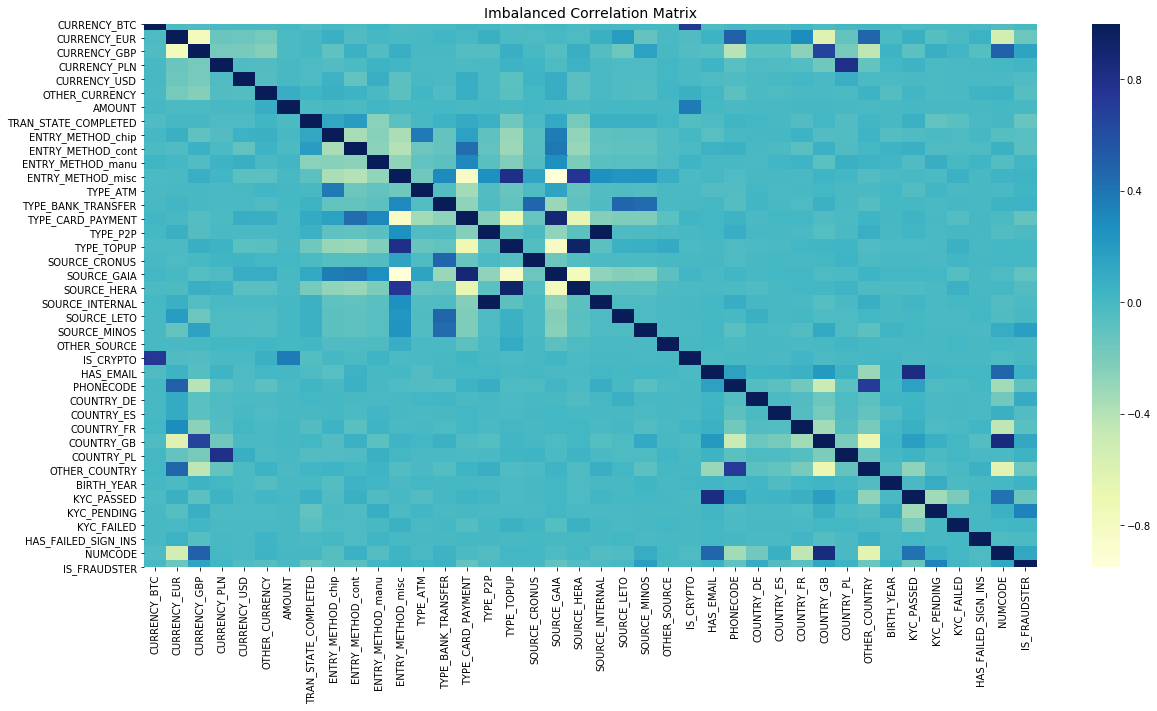

In [30]:
X_tmp = pd.DataFrame(X_res, columns=X.columns)
X_tmp['IS_FRAUDSTER'] = y_res
# X_tmp.head()
corr = X_tmp.corr()
# # corr['IS_FRAUDSTER'].sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(corr, cmap='YlGnBu', annot_kws={'size':30}, ax=ax)
ax.set_title("Imbalanced Correlation Matrix", fontsize=14)
plt.show()

In [7]:
X = pd.DataFrame(X_res, columns=X.columns)
y = y_res
params = {
    'n_estimators': range(10, 100, 5),
    'max_depth': range(1, 40),
    'min_samples_split': range(2, 10),
    'min_samples_leaf': range(1,7),
    'max_features': range(1,41)
}

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [9]:
from sklearn.linear_model import LogisticRegression

In [61]:
logic_reg_clf = LogisticRegression(random_state=0, solver='lbfgs', class_weight={1:0.95, 0:0.05}).fit(X_train, y_train)

In [62]:
predictions = logic_reg_clf.predict(X_test)
predictions

array([0, 0, 1, ..., 1, 1, 1])

In [64]:
precision_score(y_test, predictions)
recall_score(y_test, predictions)

0.83298097251585623

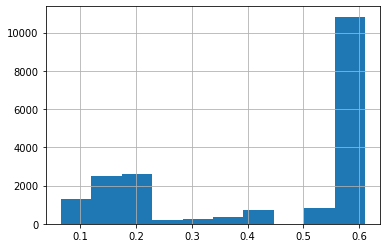

In [65]:
y_predicted_prob = logic_reg_clf.predict_proba(X_test)
pd.Series(y_predicted_prob[:, 1]).hist()

In [66]:
y_pred = np.where(y_predicted_prob[:,1] > 0.4, 1, 0)
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[ 7069, 11525],
       [   73,   873]])

In [67]:
recall_score(y_test, y_pred)

0.92283298097251587

In [68]:
precision_score(y_test, y_pred)

0.070414582997257627

In [69]:
from scipy import stats

In [ ]:
stats.kstest(x, 'norm')

In [120]:
rf = RandomForestClassifier(random_state=0, class_weight={1:0.95, 0:0.05})
search = RandomizedSearchCV(rf, params, cv=3, n_jobs=-1)
search.fit(X_train, y_train)

/home/user/.local/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/user/.local/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/user/.local/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/user/.local/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/user/.local/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops canno

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight={0: 0.05,
                                                                  1: 0.95},
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_es

In [121]:
search.best_params_

{'max_depth': 11,
 'max_features': 10,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 90}

In [122]:
best_rf = search.best_estimator_
fi = best_rf.feature_importances_
fi_df = pd.DataFrame({'features': X.columns, 'feature_importances': fi})
fi_df.sort_values('feature_importances', ascending=False)

,feature_importances,features
33,0.107607,BIRTH_YEAR
32,0.093144,OTHER_COUNTRY
26,0.087298,PHONECODE
1,0.085160,CURRENCY_EUR
2,0.061901,CURRENCY_GBP
6,0.059560,AMOUNT
7,0.052720,TRAN_STATE_COMPLETED
14,0.052410,TYPE_CARD_PAYMENT
19,0.051734,SOURCE_HERA
34,0.048966,KYC_PASSED


In [123]:
predictions = best_rf.predict(X_test)

In [124]:
precision_score(y_test, predictions)

0.32863655200994613

In [125]:
recall_score(y_test, predictions)

0.83826638477801263

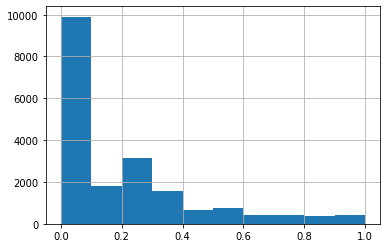

In [126]:
y_predicted_prob = best_rf.predict_proba(X_test)
pd.Series(y_predicted_prob[:, 1]).hist()

In [133]:
y_pred = np.where(y_predicted_prob[:,1] > 0.6, 1, 0)
# pd.Series(y_pred).hist()

In [134]:
precision_score(y_test, y_pred)

0.45571166768478927

In [135]:
recall_score(y_test, y_pred)

0.78858350951374212

In [136]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[17703,   891],
       [  200,   746]])

In [72]:
np.bincount(y_test)

array([18594,   946])

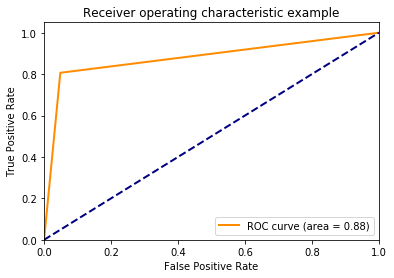

In [82]:
lw = 2
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [83]:
modelXGB = xgb.XGBRegressor().fit(X_train, y_train)

[15:22:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [87]:
xgbpredictions = modelXGB.predict(X_test)
xgbpredictions

array([ 0.01373041, -0.01600009,  0.11799595, ...,  0.03559417,
        0.03450632,  0.03262335], dtype=float32)

In [107]:
xgb_y_pred = np.where(xgbpredictions > 0.1, 1, 0)

In [92]:
mean_squared_error(y_test, xgbpredictions)

0.026270010476327873

In [108]:
precision_score(y_test, xgb_y_pred)

0.41809156094870381

In [109]:
recall_score(y_test, xgb_y_pred)

0.80126849894291752

In [110]:
confusion_matrix(y_test, xgb_y_pred)

array([[17539,  1055],
       [  188,   758]])

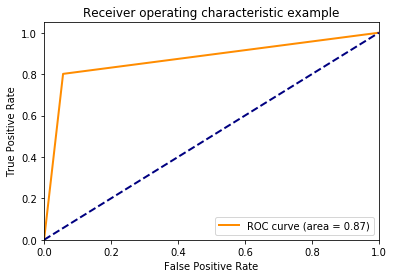

In [111]:
lw = 2
fpr, tpr, thresholds = roc_curve(y_test, xgb_y_pred)
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()